In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
#from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from scipy.spatial.distance import cdist
import os
import time

In [2]:
def plot_kalman_update_point(cluster_points, cluster_center):
    # Assuming cluster_points is a 2D numpy array with x and y coordinates
    #print(cluster_points[-5:])
    num_points = cluster_points.shape[0]
    # Generate a range of colors that go from light to dark
    colors = np.linspace(0.3, 1, num_points)  # Adjust 0.3 to 1 for darker shades
    
    # Plot the cluster points with varying darkness
    scatter = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors, cmap='Greys')
    
    # Plot the cluster center
    plt.scatter(cluster_center[0], cluster_center[1], color='red', marker='x', label='Cluster Center')
    
    # Add a colorbar, which will automatically use the 'Greys' colormap
    cbar = plt.colorbar(scatter)
    cbar.set_label('Point Intensity (later points darker)')
    
    plt.show()

def plot_dbscan_output(df, labels):
    print("###############################")
    #print(unique_labels)
    global global_counter
    global_counter +=1
    print("DBSCAN counter: ",global_counter)
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    axs[0,0].scatter(df["usec_since_Unix_Start"], df["El."], marker='o', c=labels)
    axs[0,1].scatter(df["usec_since_Unix_Start"], df["Az."], marker='o', c=labels)
    axs[1,0].scatter(df["El."], df["Az."], marker='o', c=labels)

    inds = labels > -1
    axs[1,1].scatter(df["El."][inds], df["Az."][inds], marker='o', c=labels[inds])
    # Extract x and y axis limits
    x_limits = axs[1, 1].get_xlim()
    y_limits = axs[1, 1].get_ylim()
    axs[1,1].scatter(df["El."], df["Az."], marker='o', c=labels)
    axs[1,1].set_xlim(x_limits)
    axs[1,1].set_ylim(y_limits)

    axs[2,0].scatter(df["usec_since_Unix_Start"], df["El."], marker='o', c='b')
    axs[2,1].scatter(df["usec_since_Unix_Start"], df["Az."], marker='o', c='b')
    plt.show()

def plot_log(kalman_log, file_path):
    times = []
    filter_ids = []
    predicted_xs = []
    predicted_ys = []
    
    for entry in kalman_log:
        times.append(entry['time'])
        filter_ids.append(entry['filter_id'])
        predicted_xs.append(entry['updated_x'])
        predicted_ys.append(entry['updated_y'])
    
    filter_ids = np.array(filter_ids)
    unique_ids = np.unique(filter_ids)
    print("unique tracks: ", unique_ids)
    
    # Create a custom colormap for only the used unique filter IDs
    num_unique = len(unique_ids)  # Number of unique filter IDs
    colormap = plt.get_cmap('tab10', num_unique)  # Generate a colormap for the number of unique IDs
    
    # Normalize the colormap for the unique filter IDs
    norm = mcolors.Normalize(vmin=min(unique_ids), vmax=max(unique_ids))
    
    # Create a figure with two subplots (axes)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
    
    # First scatter plot (predicted_ys)
    scatter1 = ax1.scatter(times, predicted_ys, c=filter_ids, s = 3, cmap=colormap, norm=norm, alpha=0.1)
    ax1.set_ylim(-180, 200)
    ax1.set_ylabel("Azimuth")
    
    # Create a ScalarMappable for the color bar to use only the available filter IDs
    sm1 = ScalarMappable(cmap=colormap, norm=norm)
    sm1.set_array([])  # Required for ScalarMappable
    
    # Add a colorbar with only the colors used in the plot
    cbar1 = fig.colorbar(sm1, ax=ax1, ticks=unique_ids, label="Track IDs")
    
    # Shade the regions specified by grouped_time_intervals
    for interval in grouped_time_intervals:
        ax1.axvspan(interval[0], interval[1], color='gray', alpha=0.1)
    
    # Second scatter plot (predicted_xs)
    scatter2 = ax2.scatter(times, predicted_xs, c=filter_ids, s =3,  cmap=colormap, norm=norm, alpha=0.1)
    ax2.set_ylim(30, 200)
    ax2.set_ylabel("Elevation")
    ax2.set_xlabel("Time")
    
    # Create a ScalarMappable for the second color bar to use only the available filter IDs
    sm2 = ScalarMappable(cmap=colormap, norm=norm)
    sm2.set_array([])
    
    # Add a colorbar with only the colors used in the plot
    cbar2 = fig.colorbar(sm2, ax=ax2, ticks=unique_ids, label="Track IDs")
    
    # Shade the regions specified by grouped_time_intervals
    for interval in grouped_time_intervals:
        ax2.axvspan(interval[0], interval[1], color='gray', alpha=0.1)
    
    # Adjust layout to ensure no overlapping
    plt.tight_layout()
    
    # Extract the base path from the file path and create the output file path
    base_path = os.path.splitext(file_path.split('/')[-1])[0]  # Remove file extension
    output_path = base_path + "_plot.png"  # Append desired file name extension
    
    # Save the figure to the output path
    plt.savefig(output_path, dpi=300)
    print(f"Plot saved to {output_path}")
    
    # Display the

def PrintInfo(distance_matrix, associations, unassigned_clusters):
    print("distance matrix")
    print(distance_matrix)
    print(f"associations: {associations}")
    print(f"unassigned_clusters: {unassigned_clusters}")
    for c in unassigned_clusters:
        print("Initializing new filter for cluster: ", c)


def el_az_to_cartesian(az_el_pairs):
    """
    Transforms a single azimuth-elevation pair or a list of pairs into Cartesian coordinates.
    
    Parameters:
    az_el_pairs : array-like
        A single pair [azimuth, elevation] or a list of pairs [[azimuth1, elevation1], [azimuth2, elevation2], ...]
        
    Returns:
    Cartesian coordinates as an array of (x, y, z) tuples.
    """
    
    # Ensure az_el_pairs is a numpy array for consistent handling
    az_el_pairs = np.array(az_el_pairs)
    
    # If it's a single pair, reshape to handle it as a list with one entry
    if az_el_pairs.ndim == 1:
        az_el_pairs = az_el_pairs.reshape(1, -1)
    
    # Separate azimuth and elevation angles
    elevation_deg = az_el_pairs[:, 0]
    azimuth_deg = az_el_pairs[:, 1]
    
    
    # Convert degrees to radians
    azimuth_rad = np.radians(azimuth_deg)
    elevation_rad = np.radians(elevation_deg)
    
    # Perform the transformation to Cartesian coordinates
    x = np.cos(azimuth_rad) * np.cos(elevation_rad)
    y = np.sin(azimuth_rad) * np.cos(elevation_rad)
    z = np.sin(elevation_rad)
    
    # Combine into a single array of Cartesian coordinates
    cartesian_coords = np.column_stack((x, y, z))
    
    return cartesian_coords

def cartesian_to_az_el(x, y, z):
    hyp = np.sqrt(x**2 + y**2)
    azimuth_rad = np.arctan2(y, x)
    elevation_rad = np.arctan2(z, hyp)
    azimuth_deg = np.degrees(azimuth_rad) % 360
    elevation_deg = np.degrees(elevation_rad)
    return azimuth_deg, elevation_deg


def DOA_to_ElAz(df):
    """
    Calculate elevation and azimuth angles from DOA vectors in a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'DOA_x', 'DOA_y', 'DOA_z' columns.

    Returns:
    pandas.DataFrame: The original DataFrame with added 'El.' and 'Az.' columns.
    """
    # Ensure the DOA components are present in the DataFrame
    required_columns = {'DOA_x', 'DOA_y', 'DOA_z'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"DataFrame must contain the columns: {required_columns}")

    # Calculate elevation angle (El.)
    df['El.'] = 180.0 - np.degrees(np.arccos(df['DOA_z']))

    # Calculate azimuth angle (Az.)
    df['Az.'] = np.degrees(np.arctan2(df['DOA_y'], df['DOA_x']))

    # Optional: Ensure azimuth values are within [0, 360) degrees
    df['Az.'] = df['Az.'] % 360

    return df

def doa_to_ElAz(x,y,z):
    el = 180.0 - np.degrees(np.arccos(z))
    az = np.degrees(np.arctan2(y, x))
    return el, az

/tmp/ipykernel_11888/1731789377.py:316: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path_doa, delim_whitespace=True, names=column_names, skiprows=1)


###############################
DBSCAN counter:  1


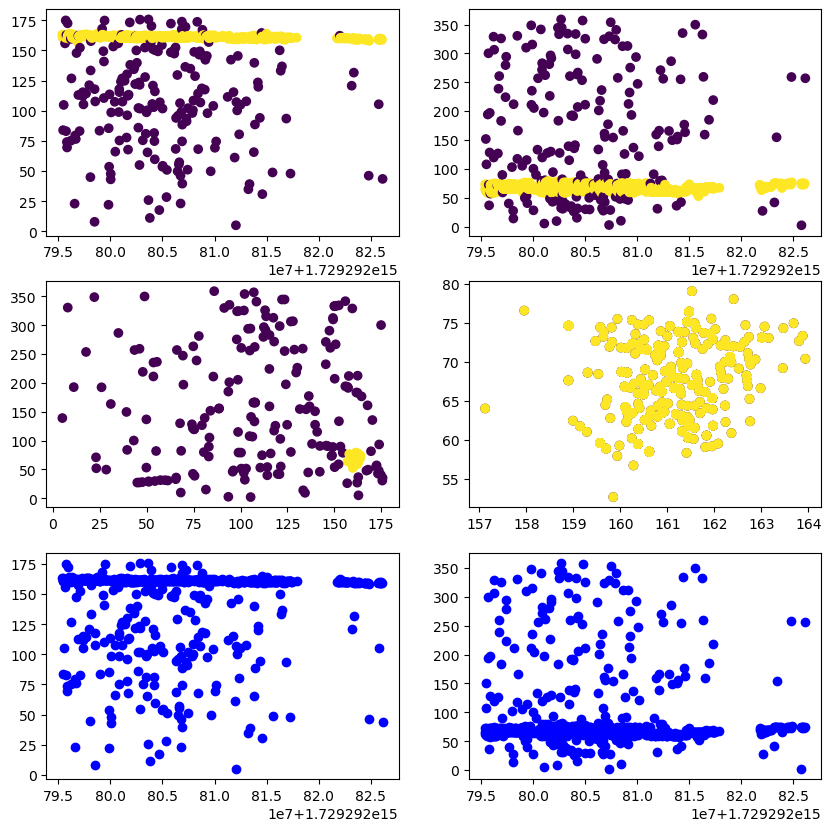

[[0.09829667 0.34107    0.93483333]]
distance matrix
[]
associations: []
unassigned_clusters: [0]
Initializing new filter for cluster:  0
###############################
DBSCAN counter:  2


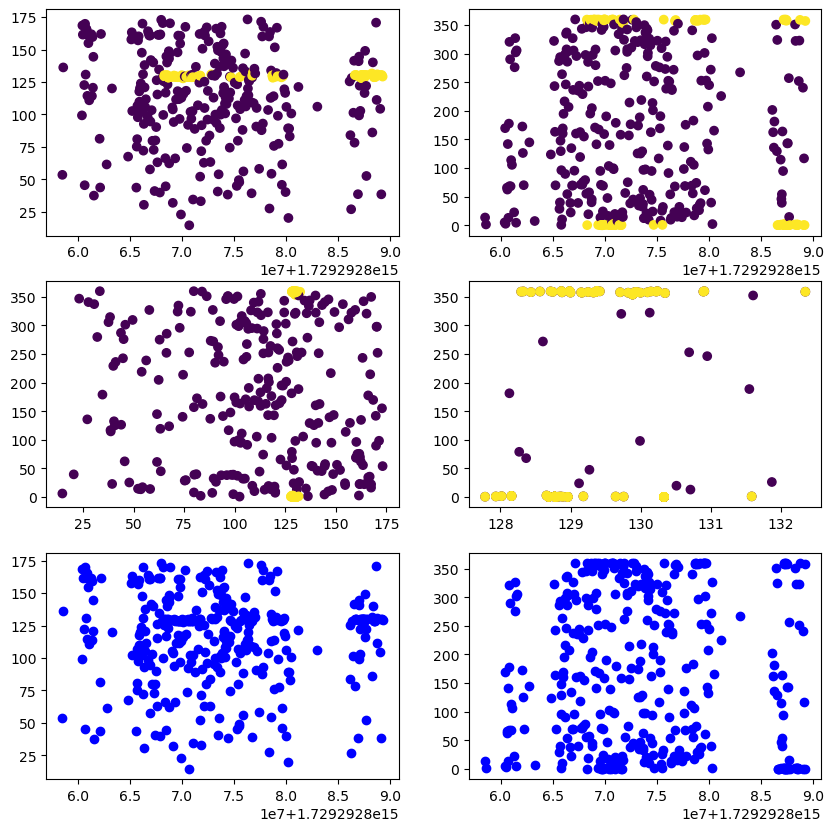

[[ 0.76636    -0.01000333  0.64196   ]]
distance matrix
[[0.77309165]]
associations: [-1]
unassigned_clusters: [0]
Initializing new filter for cluster:  0
###############################
DBSCAN counter:  3


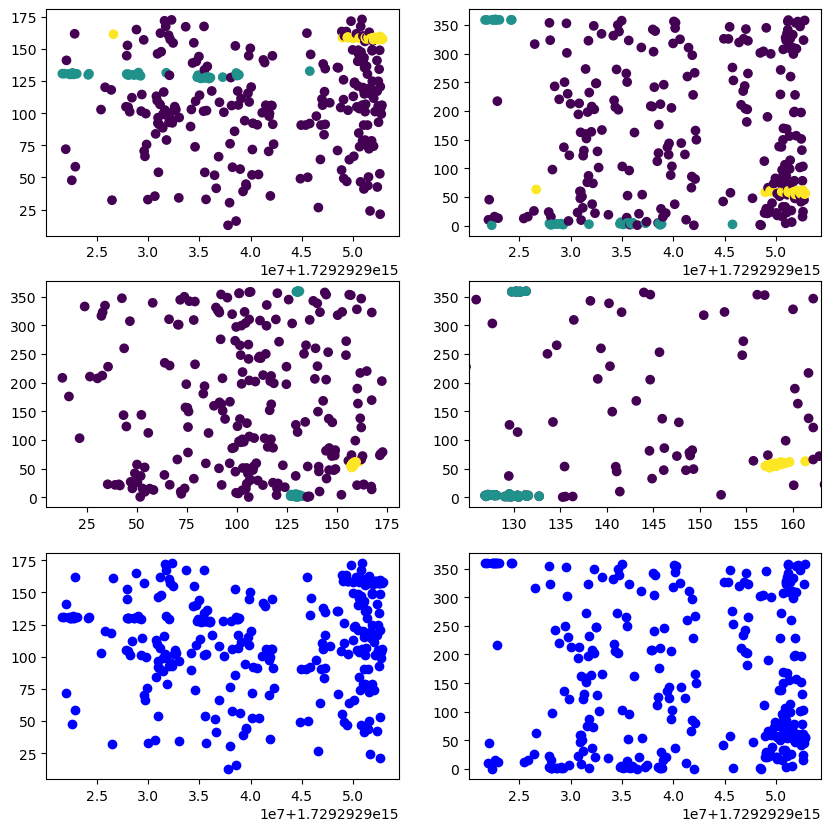

[[0.75781    0.02713    0.65137333]
 [0.21376    0.31274667 0.92545   ]]
distance matrix
[[0.67796787 0.00612629]
 [0.03892179 0.64274933]]
associations: [1, 0]
unassigned_clusters: []
###############################
DBSCAN counter:  4


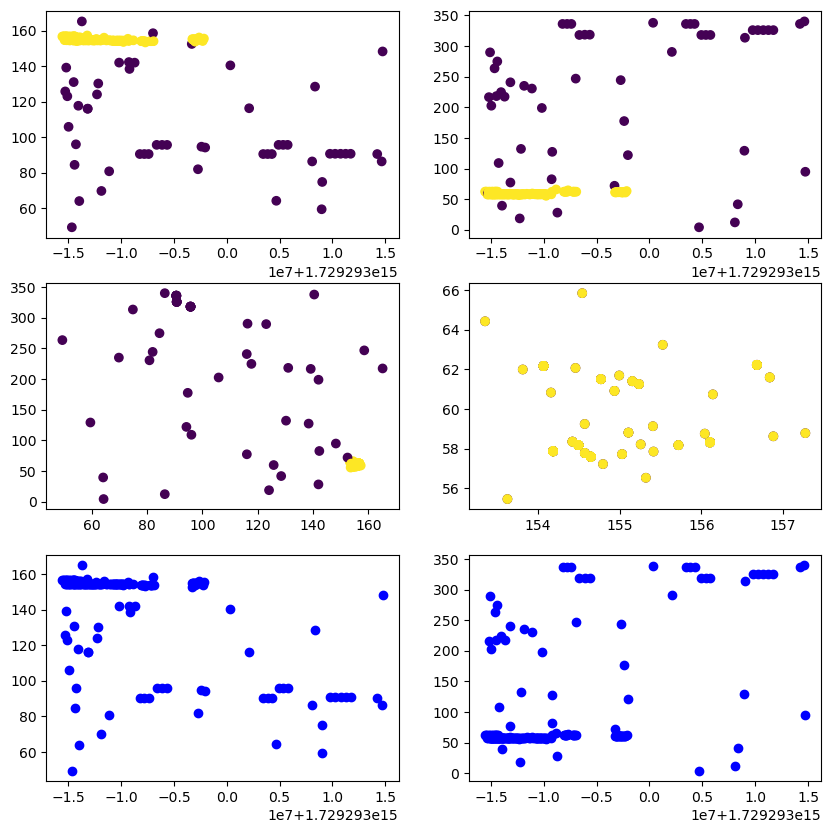

[[0.20075    0.37506333 0.90491667]]
distance matrix
[[0.00728331]
 [0.68588811]]
associations: [0, -1]
unassigned_clusters: []
###############################
DBSCAN counter:  5


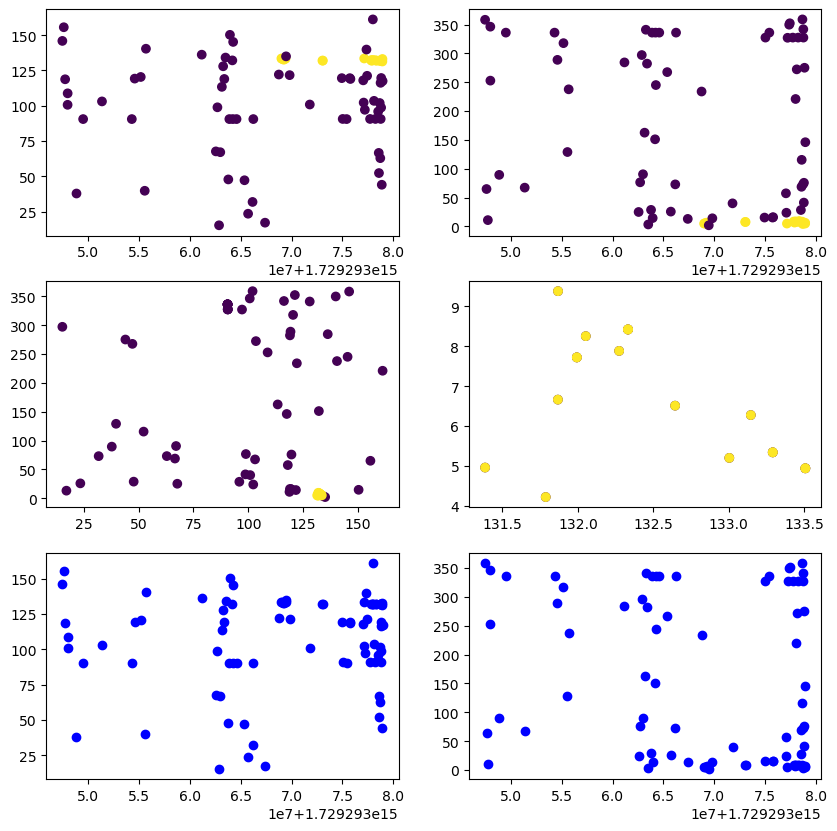

[[0.73877667 0.06649    0.67044667]]
distance matrix
[[0.67475353]
 [0.02960277]]
associations: [-1, 0]
unassigned_clusters: []
###############################
DBSCAN counter:  6


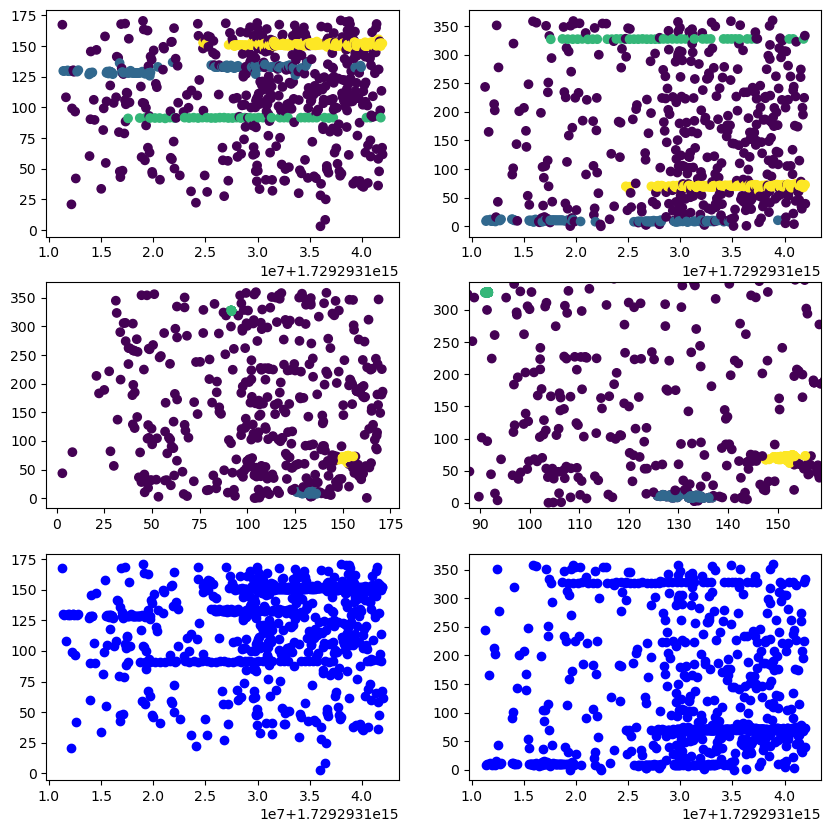

[[ 0.71752     0.13558     0.68306333]
 [ 0.84203    -0.53869     0.02828   ]
 [ 0.13986     0.44532667  0.88437667]]
distance matrix
[[0.68269449 1.47865552 0.00446038]
 [0.00859021 0.95220263 0.67874957]]
associations: [2, 0]
unassigned_clusters: [1]
Initializing new filter for cluster:  1
###############################
DBSCAN counter:  7


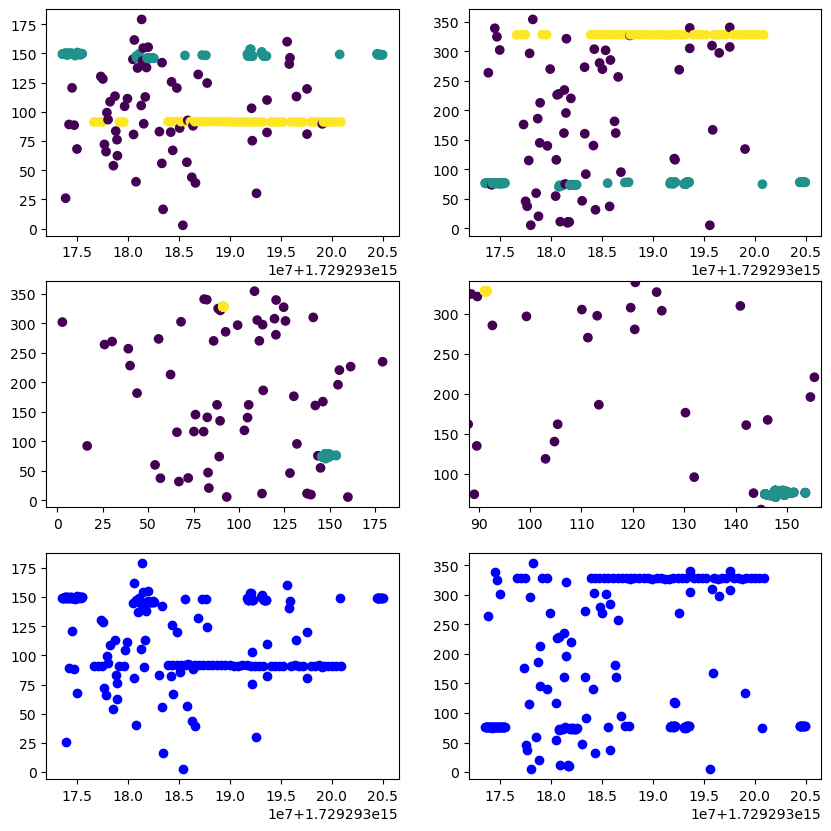

[[ 0.10438  0.50587  0.85627]
 [ 0.84997 -0.52637  0.02206]]
distance matrix
[[1.79862706e-03 1.52320922e+00]
 [6.63509585e-01 1.00713196e+00]
 [1.52275217e+00 9.33763033e-04]]
associations: [0, -1, 1]
unassigned_clusters: []
###############################
DBSCAN counter:  8


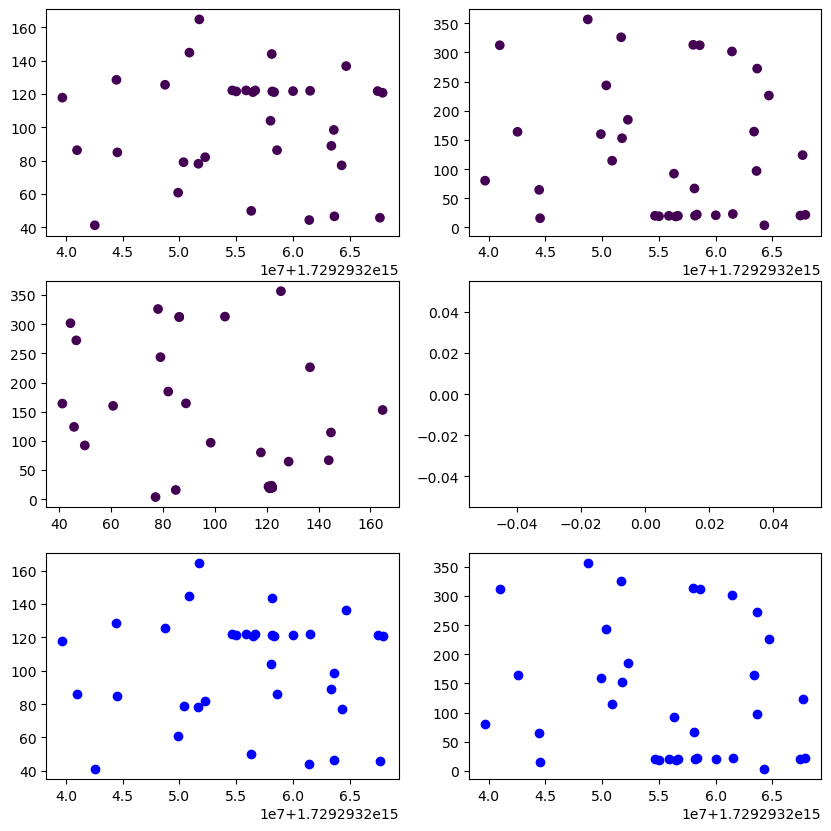

[]
distance matrix
[]
associations: [-1, -1, -1]
unassigned_clusters: []
###############################
DBSCAN counter:  9


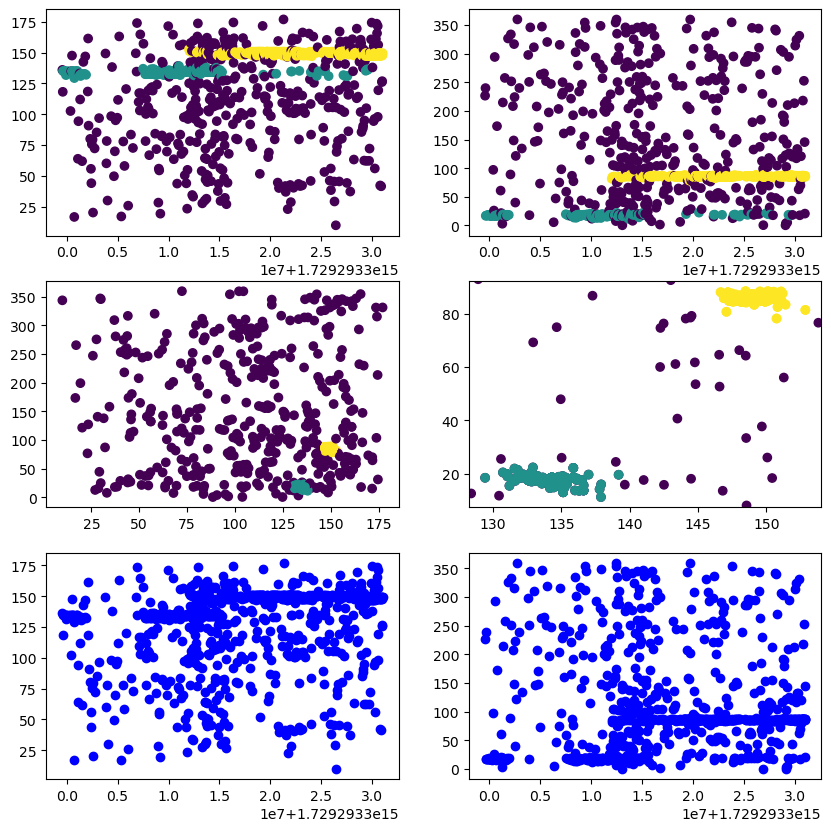

[[0.66084    0.21438333 0.71919   ]
 [0.03589667 0.51633    0.85551333]]
distance matrix
[[0.71410651 0.01028459]
 [0.06738369 0.73980655]
 [0.99467597 1.53680413]]
associations: [1, -1, -1]
unassigned_clusters: [0]
Initializing new filter for cluster:  0
###############################
DBSCAN counter:  10


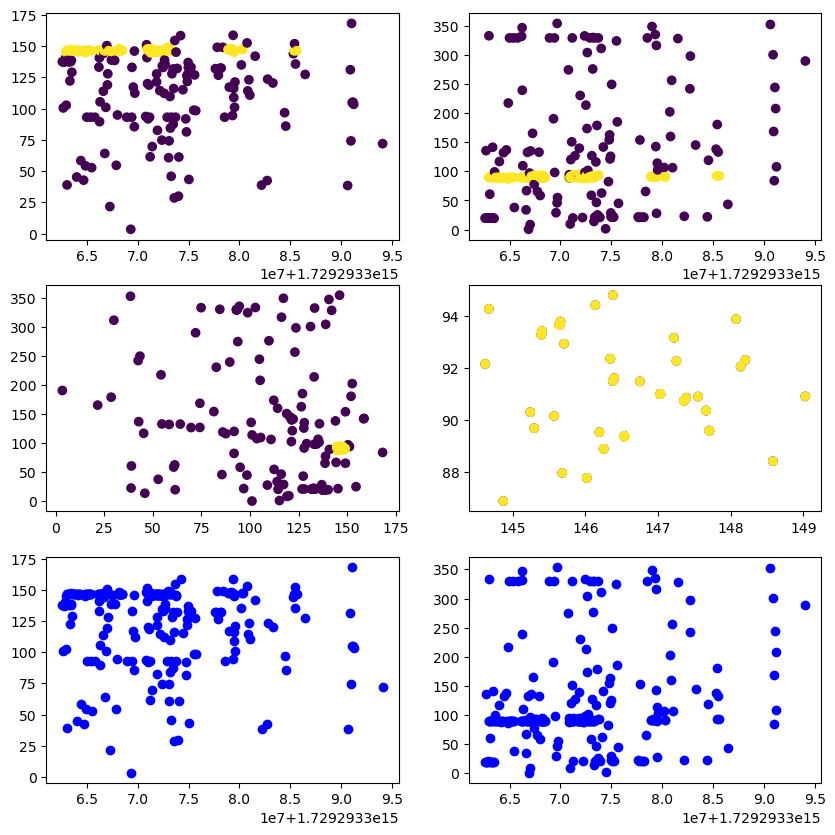

[[-0.01755333  0.54893667  0.83560667]]
distance matrix
[[0.002551  ]
 [0.79690441]
 [1.56158651]
 [0.64261055]]
associations: [0, -1, -1, -1]
unassigned_clusters: []


In [3]:
"""
This is a program that performs multi-target tracking. 
Initially, clustering (DBSCAN) is performed on a batch of samples to estimate the number of targets. 
A kalman filter is then initialized for each cluster (i.e. target).
New observations are used to either update an existing kalman filter's state or ignored as noise.
Periodically, batches of observations are used to perform clustering to update the number of targets. 
Each cluster is either associated with an existing kalman filter or used to initialize a new kalman filter.
If a kalman filter is not assocaited with a cluster for a specified number of clustering iterations, the filter is destroyed.
"""
global_counter = 0
class KalmanFilter:
    def __init__(self,
                 transition_matrices,
                 observation_matrices,
                 initial_state_mean,
                 initial_state_covariance,
                 transition_covariance,
                 observation_covariance):
        self.F = np.array(transition_matrices)  # State transition matrix
        self.H = np.array(observation_matrices)  # Observation matrix
        self.Q = np.array(transition_covariance)  # Process noise covariance
        self.R = np.array(observation_covariance)  # Measurement noise covariance
        self.x = np.array(initial_state_mean)  # Initial state estimate
        self.P = np.array(initial_state_covariance)  # Initial covariance estimate

    def predict(self):
        # Predict the state estimate and covariance
        self.x_prior = self.F @ self.x
        self.P_prior = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        assert z.shape == (3,), f"Observation z has incorrect shape: {z.shape}"
        
        # Compute innovation
        y = z - self.H @ self.x_prior
        assert y.shape == (3,), f"Innovation y has incorrect shape: {y.shape}"
        # Compute innovation covariance
        S = self.H @ self.P_prior @ self.H.T + self.R
        # Compute Kalman gain
        K = self.P_prior @ self.H.T @ np.linalg.inv(S)
        assert K.shape == (6, 3), f"Kalman gain K has incorrect shape: {K.shape}"
        # Update state estimate
        self.x = self.x_prior + K @ y
        # Update covariance estimate
        self.P = (np.eye(self.P_prior.shape[0]) - K @ self.H) @ self.P_prior

    def filter_update(self, filtered_state_mean=None, filtered_state_covariance=None, observation=None):
        # If filtered_state_mean and covariance are provided, update self.x and self.P
        if filtered_state_mean is not None:
            self.x = np.array(filtered_state_mean)
        if filtered_state_covariance is not None:
            self.P = np.array(filtered_state_covariance)
        # Predict
        self.predict()
        # Update if observation is provided
        if observation is not None:
            self.update(observation)
        else:
            # If no observation, update x and P with predicted values
            self.x = self.x_prior
            self.P = self.P_prior
        return self.x, self.P

class Tracker:
    def __init__(self, eps=.052, min_samples=15, missed_update_threshold=4):
        # DBSCAN parameters
        self.eps = eps  # Max distance between two points to be considered as in the same neighborhood
        self.min_samples = min_samples  # Minimum number of points to form a cluster

        # Initialize storage for Kalman filters and logs
        self.kalman_filters = []
        self.cluster_assignments = []  # To track which Kalman filter corresponds to which cluster
        self.kalman_log = []  # To log the outputs of the Kalman filter

        self.global_counter = 0

        self.missed_update_threshold = missed_update_threshold  # Number of iterations a filter can go without being updated before removal
        self.missed_updates = []  # Track how many iterations each filter has missed being associated with a cluster
        self.next_label = 0

    # Function to initialize a Kalman filter given the initial position
    def initialize_kalman_filter(self, initial_state):
        # State transition matrix: assuming constant velocity model in 3D
        transition_matrix = np.array([
            [1, 0, 0, 1, 0, 0],  # X -> X + Vx
            [0, 1, 0, 0, 1, 0],  # Y -> Y + Vy
            [0, 0, 1, 0, 0, 1],  # Z -> Z + Vz
            [0, 0, 0, 1, 0, 0],  # Vx -> Vx
            [0, 0, 0, 0, 1, 0],  # Vy -> Vy
            [0, 0, 0, 0, 0, 1],  # Vz -> Vz
        ])
    
        # Observation matrix: we can only observe position, not velocity
        observation_matrix = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
        ])
    
        # Initial state covariance
        initial_state_covariance = np.eye(6) * 1000
    
        # Process noise covariance
        process_covariance = np.eye(6) * 0.01 *100
    
        # Observation noise covariance
        observation_covariance = np.eye(3) * 10 *100
    
        # Initial state vector [X, Y, Z, Vx, Vy, Vz]
        initial_state_mean = np.array([*initial_state, 0, 0, 0])

        # Create the Kalman filter
        kf = KalmanFilter(
            transition_matrices=transition_matrix,
            observation_matrices=observation_matrix,
            initial_state_mean=initial_state_mean,
            initial_state_covariance=initial_state_covariance,
            transition_covariance=process_covariance,
            observation_covariance=observation_covariance
        )

        return kf

    # Function to run DBSCAN
    def run_dbscan(self, df):
        self.global_counter += 1
        X = df[["DOA_x", "DOA_y", "DOA_z"]].values
        #print(X)
        #X = el_az_to_cartesian(X)
        db = DBSCAN(eps=self.eps, min_samples=self.min_samples).fit(X)
        labels = db.labels_

        ##################################
        plot_dbscan_output(df, labels)
        ##################################

        # Extract cluster end regions
        cluster_centers = self.get_cluster_centroids(X, labels)

        return cluster_centers

    # Function to find optimal association
    def find_optimal_association(self, distance_matrix, threshold):
        num_kalman_filters, num_new_clusters = distance_matrix.shape

        # Step 1: Ignore new clusters where all distances to prior clusters are greater than the threshold
        unassociated_new_clusters = []
        associated_new_clusters = []
        for new_cluster in range(num_new_clusters):
            if np.all(distance_matrix[:, new_cluster] > threshold):
                unassociated_new_clusters.append(new_cluster)
            else:
                associated_new_clusters.append(new_cluster)

        # Step 2: Assign new clusters to prior clusters based on smallest valid distance
        associations = [-1] * num_kalman_filters  # Initialize associations with -1 (no association)
        assigned_new_clusters = set()  # To track already assigned new clusters

        for klm_ind in range(num_kalman_filters):
            min_distance = float('inf')
            best_new_cluster = -1
            for new_cluster in associated_new_clusters:
                if distance_matrix[klm_ind, new_cluster] < threshold and new_cluster not in assigned_new_clusters:
                    if distance_matrix[klm_ind, new_cluster] < min_distance:
                        min_distance = distance_matrix[klm_ind, new_cluster]
                        best_new_cluster = new_cluster
            if best_new_cluster != -1:
                associations[klm_ind] = best_new_cluster
                assigned_new_clusters.add(best_new_cluster)

        return associations, unassociated_new_clusters

    """
    def calculate_distance_matrix(self, cluster_centers):
        distance_matrix = np.zeros((len(self.kalman_filters), len(cluster_centers)))
        if len(self.kalman_filters) != 0 and len(cluster_centers) !=0:
            #predicted_state_means = np.array([kf.predict().x_prior[:2] for kf in self.kalman_filters])
            predicted_state_means = np.array([kf.x_prior[:2] for kf in self.kalman_filters])
            # Calculate the distance matrix using broadcasting
            distance_matrix = np.linalg.norm(predicted_state_means[:, np.newaxis, :] - cluster_centers[np.newaxis, :, :], axis=2)
        return distance_matrix
    """
    def calculate_distance_matrix(self, cluster_centers):
        distance_matrix = np.zeros((len(self.kalman_filters), len(cluster_centers)))
        if len(self.kalman_filters) != 0 and len(cluster_centers) != 0:
            predicted_state_means = np.array([kf.x_prior[:3] for kf in self.kalman_filters])
            distance_matrix = np.linalg.norm(predicted_state_means[:, np.newaxis, :] - cluster_centers[np.newaxis, :, :], axis=2)
        return distance_matrix
    
    def destroy_expired_filters(self):
        # Create a list of indices for filters to keep (those that haven't missed too many updates)
        indices_to_keep = [i for i, count in enumerate(self.missed_updates) if count <= self.missed_update_threshold]

        # Filter kalman_filters, cluster_assignments, and missed_updates using the same indices
        self.kalman_filters = [self.kalman_filters[i] for i in indices_to_keep]
        self.missed_updates = [self.missed_updates[i] for i in indices_to_keep]
        self.cluster_assignments = [self.cluster_assignments[i] for i in indices_to_keep]

    def get_cluster_centroids(self, X, labels):        
        cluster_centers = []
        unique_labels = np.unique(labels)
        for label in unique_labels:
            if label != -1:  # Exclude noise points
                cluster_points = X[labels == label]
                cluster_center = cluster_points[-3:].mean(axis=0)  # Use last 3 points for averaging
                cluster_centers.append(cluster_center)
        return np.array(cluster_centers)

    def increment_missed_counter(self, associated_filters):
        for i in range(len(self.kalman_filters)):
            if i not in associated_filters:
                self.missed_updates[i] += 1

    def initialize_filters_for_clusters(self, unassigned_clusters, cluster_centers):
        for c in unassigned_clusters:
            # Initialize a new Kalman filter for this unassigned cluster center
            new_kf = self.initialize_kalman_filter(cluster_centers[c])
            self.kalman_filters.append(new_kf)

            # Assign a new unique label to this filter
            self.cluster_assignments.append(self.next_label)
            self.next_label += 1

            # Initialize the missed update count for the new filter
            self.missed_updates.append(0)
        
    # Function to update or initialize Kalman filters based on DBSCAN results
    def update_kalman_filters(self, cluster_centers):
        
        #Compute the pairwise distance matrix between Kalman filter predictions and cluster centers
        distance_matrix = self.calculate_distance_matrix(cluster_centers)

        #Solve the optimal assignment using the custom find_optimal_association function
        associations, unassigned_clusters = self.find_optimal_association(distance_matrix, self.eps)

        # To track filters that are associated with a cluster
        associated_filters = set()  
        for r, c in enumerate(associations):
            if c >= 0:  # Check if cluster was assigned
                # Update the Kalman filter with its associated cluster.. may not be necessary
                #kf = self.kalman_filters[r]
                #kf.update(cluster_centers[c])
                associated_filters.add(r)
                self.missed_updates[r] = 0  # Reset the missed count

        self.initialize_filters_for_clusters(unassigned_clusters, cluster_centers)

        PrintInfo(distance_matrix, associations, unassigned_clusters)
        # Increment missed_count for all non-associated filters
        self.increment_missed_counter(associated_filters)

        self.destroy_expired_filters()

    # Function to update the associated Kalman filters from a sample
    def update_kalman_filters_continuous(self, observation, time):
        best_match = None
        best_dist = .14  # Adjusted the gating_threshold to be consistent

        # Find the Kalman filter with the closest prediction to the current observation
        for idx, kf in enumerate(self.kalman_filters):
            # Predict the next state with the Kalman filter
            kf.predict()
            predicted_state_mean = kf.H @ kf.x_prior
            #predicted_state_mean = kf.x_prior[:2]
            
            # Calculate the distance from the predicted position to the observation
            dist = np.linalg.norm(predicted_state_mean - observation)

            if dist < best_dist:
                best_dist = dist
                best_match = idx

        # If a valid match is found, update the corresponding Kalman filter
        if best_match is not None:
            kf = self.kalman_filters[best_match]
            kf.update(observation)

            el, az = doa_to_ElAz(kf.x[0],kf.x[1],kf.x[2])

            
            # Log the updated state
            self.kalman_log.append({
                'time': time,
                'filter_id': self.cluster_assignments[best_match],
                'updated_x': el,
                'updated_y': az
            })


    # Function to handle batch updates
    def process_batch(self, df_current):
        cluster_centers = self.run_dbscan(df_current)
        print(cluster_centers)
        #if len(cluster_centers) == 0:
        #    return  # No valid clusters
        self.update_kalman_filters(cluster_centers)


# Load the data as per your existing code
column_names = [
    "usec_since_Unix_Start", "Energy", "DOA_x", "DOA_y", "DOA_z", "TDOA12", "TDOA13", "TDOA14",
    "TDOA23", "TDOA24", "TDOA34", "Xcorr12", "Xcorr13", "Xcorr14",
    "Xcorr23", "Xcorr24", "Xcorr34"
]

# Replace with your actual data path
path_doa = "../../C/deployment_files/2024-8-29-18-37-36-480140_detection"
path_doa = "../../C/deployment_files/2024-10-1-17-28-35-306897_detection"
path_doa = "../../C/deployment_files/2024-10-1-15-19-31-643613_detection"
#path_doa = "../../C/deployment_files/2024-10-1-15-55-32-804596_detection" #track154
#path_doa = "../../C/deployment_files/2024-10-1-16-41-10-645933_detection" #track103
#path_doa = "../../C/deployment_files/test_this.txt" #132
path_doa = "../../C/deployment_files/track_154.txt" #132

#path_doa = "../2024-9-12-9-36-14-51349_detection"
df = pd.read_csv(path_doa, delim_whitespace=True, names=column_names, skiprows=1)

# Instantiate the tracker
tracker = Tracker(eps=.04, min_samples=15, missed_update_threshold=4) #.027 same until 7

# Main processing loop (outside the class)
time_intervals = np.linspace(df["usec_since_Unix_Start"].min(), df["usec_since_Unix_Start"].max(), num=20)
grouped_time_intervals = []

for ind in range(len(time_intervals) - 1):
    # Select the data within the current interval
    observations = df[
        (df["usec_since_Unix_Start"] > time_intervals[ind]) &
        (df["usec_since_Unix_Start"] <= time_intervals[ind + 1])
    ]
    
    # Remove rows with any NaN values
    observations = observations.dropna()
    
    # If there are no data points in this interval, skip to the next iteration
    if observations.empty:
        continue
    observations = DOA_to_ElAz(observations)
    #print(observations)
    #adsf
    #observations = observations.iloc[:, 2:5]
    #print(observations)
    #asdfa

    # Run DBSCAN on even intervals
    if ind % 2 == 0:
        if ind != 0:
            for _, row in observations.iterrows():
                observation = [row["DOA_x"], row["DOA_y"], row["DOA_z"]]
                #print(observation)
                #observation = el_az_to_cartesian(observation)
                observation = np.squeeze(observation)
                #print(observation)
                tracker.update_kalman_filters_continuous(observation, row['usec_since_Unix_Start'])

        grouped_time_intervals.append([time_intervals[ind], time_intervals[ind + 1]])
        tracker.process_batch(observations) # Handle batch updates
    else:
        # For odd intervals, handle individual sample updates
        for _, row in observations.iterrows():
            observation = [row["DOA_x"], row["DOA_y"], row["DOA_z"]]
            #observation = [row["El."], row["Az."]]
            #print(observation)
            #observation = el_az_to_cartesian(observation)
            observation = np.squeeze(observation)
            #print(observation)
            tracker.update_kalman_filters_continuous(observation, row['usec_since_Unix_Start'])

unique tracks:  [0 1 2 3]
Plot saved to track_154_plot.png
4


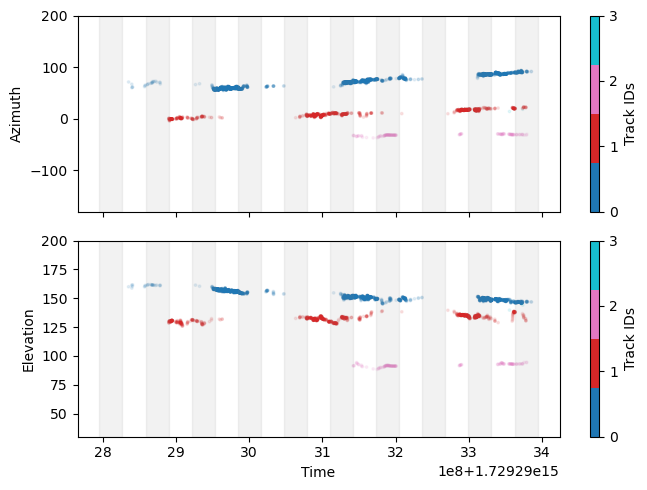

In [4]:
plot_log(tracker.kalman_log, path_doa)
print(len(tracker.kalman_filters))

In [5]:
np.array([2,4])

array([2, 4])